import librqaries

In [39]:
import requests
from bs4 import BeautifulSoup
import os
import json
from PIL import Image
from io import BytesIO
from datetime import datetime
import csv

get response

In [19]:
# URL and Headers
url = 'https://unsplash.com/'
Headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.',
    'Accept-Language': 'en-US,en;q=0.5'
}
response = requests.get(url, headers=Headers)
print(response.status_code)

200


find links

In [20]:
# Parse HTML and Extract Image Links
soup = BeautifulSoup(response.text, 'html.parser')
img_tags = soup.find_all('img')

# Extract the image links (considering srcset as well)
image_links = []
for img in img_tags:
    if 'srcset' in img.attrs:
        # srcset can have multiple image URLs, usually we take the first one
        srcset = img['srcset'].split(',')[0]
        image_links.append(srcset.split(' ')[0])
    elif 'src' in img.attrs:
        image_links.append(img['src'])
# print the number of image links found and the first few links for verification
print(f'Found {len(image_links)} image links.')
print(image_links[:5])  # Print the first 5 image links for verification
# create directory for images
os.makedirs('unsplash_images', exist_ok=True)
# Download image and save Metadata -> JSON
metadata_list = []

Found 191 image links.
['https://unsplash-assets.imgix.net/unsplashplus/asset-plus-017.jpg?dpr=1&h=304&w=304&crop=focalpoint&fp-y=0.4&auto=format&fit=crop&q=60', 'https://unsplash-assets.imgix.net/unsplashplus/asset-plus-018.jpg?dpr=1&h=304&w=304&crop=focalpoint&fp-y=0.51&auto=format&fit=crop&q=60', 'https://unsplash-assets.imgix.net/unsplashplus/asset-plus-004.jpg?dpr=1&h=304&w=304&crop=faces&auto=format&fit=crop&q=60', 'https://unsplash-assets.imgix.net/unsplashplus/asset-plus-005.jpg?dpr=1&h=304&w=304&crop=faces&auto=format&fit=crop&q=60', 'https://unsplash-assets.imgix.net/unsplashplus/asset-plus-017.jpg?dpr=1&h=304&w=304&auto=format&fit=crop&q=60']


serial part


In [40]:
start_time_cell_1 = datetime.now()

summary_data = []

# create main directory for images and metadata
main_image_dir = 'unsplash_images'
os.makedirs(main_image_dir, exist_ok=True)

# Step 1 download images /////and create empty [JSON] files
for num, link in enumerate(image_links):
    try:
        response = requests.get(link)
        if response.status_code == 200:
            img_dir = os.path.join(main_image_dir, f'image_{num}')
            os.makedirs(img_dir, exist_ok=True)

            img_name = 'image.jpg'
            img_path = os.path.join(img_dir, img_name)
            with open(img_path, 'wb') as f:
                f.write(response.content)
            print(f'downloaded!!!!! {img_name} in {img_dir}')
            
            
            img = Image.open(BytesIO(response.content))# load the image to get metadata
            img_format = img.format
            img_size = img.size
            img_mode = img.mode
            
            # Prepare metadata
            metadata = {
                "url": link,
                "format": img_format,
                "size": img_size,
                "mode": img_mode
            }


            # JSON file
            json_path = os.path.join(img_dir, 'metadata.json')
            with open(json_path, 'w') as json_file:
                json.dump(metadata, json_file, indent=4)
            print(f"Created empty JSON file for {img_name} in {img_dir}")
            
            
            # data for summary report
            summary_data.append({
                'image_dir': img_dir,
                'image_url': link,
                'format': img_format,
                'size': img_size,
                'mode': img_mode
            })
        else:
            print(f"Failed to download {link}: code {response.status_code}")
    except Exception as e:
        print(f"Error {link}: {e}")


# summary report CSV
csv_file_path = 'summary_report.csv'
with open(csv_file_path, 'w', newline='') as csv_file:
    fieldnames = ['image_dir', 'image_url', 'format', 'size', 'mode']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    
    writer.writeheader()
    for data in summary_data:
        writer.writerow(data)


end_time_cell_1 = datetime.now()

Downloaded image.jpg in unsplash_images\image_0
Created empty JSON file for image.jpg in unsplash_images\image_0
Downloaded image.jpg in unsplash_images\image_1
Created empty JSON file for image.jpg in unsplash_images\image_1
Downloaded image.jpg in unsplash_images\image_2
Created empty JSON file for image.jpg in unsplash_images\image_2
Downloaded image.jpg in unsplash_images\image_3
Created empty JSON file for image.jpg in unsplash_images\image_3
Downloaded image.jpg in unsplash_images\image_4
Created empty JSON file for image.jpg in unsplash_images\image_4
Downloaded image.jpg in unsplash_images\image_5
Created empty JSON file for image.jpg in unsplash_images\image_5
Downloaded image.jpg in unsplash_images\image_6
Created empty JSON file for image.jpg in unsplash_images\image_6
Downloaded image.jpg in unsplash_images\image_7
Created empty JSON file for image.jpg in unsplash_images\image_7
Downloaded image.jpg in unsplash_images\image_8
Created empty JSON file for image.jpg in unsplas

ai tag part (serial)

In [22]:
#API key
main_image_dir = 'unsplash_images'
PHOTO_TAG_API_KEY = '8XhH-GajH-QzVO-wsMI'
PHOTO_TAG_API_URL = 'https://server.phototag.ai/api/keywords'

In [35]:
start_time_cell_2 = datetime.now()

#get tags from PhotoTag.ai
def get_tags_from_phototag(image_path):
    try:
        headers = {
            "Authorization": f'Bearer 8XhH-GajH-QzVO-wsMI'
        }
        payload = {
            "language": "en",
            "maxKeywords": 5,
            "requiredKeywords": "beach,sky",
            "customContext": "vacation photo"
        }
        files = [
            ('file', open(image_path, 'rb'))
        ]
        
        response = requests.post(PHOTO_TAG_API_URL, headers=headers, data=payload, files=files)
        
        if response.status_code == 200:
            metadata = response.json()
            return metadata
        else:
            print(f"Failed to get tags for {image_path}: Status code {response.status_code}, Response: {response.text}")
            return {'tags': []}
    except Exception as e:
        print(f"Error occurred while getting tags for {image_path}: {e}")
        return {'tags': []}

#update JSON file metadata
def update_json_with_metadata(img_dir, image_url):
    img_path = os.path.join(img_dir, 'image.jpg')
    json_path = os.path.join(img_dir, 'metadata.json')
    
    if os.path.exists(img_path) and os.path.exists(json_path):
        metadata = get_tags_from_phototag(img_path)
        metadata.update({
            'image_name': 'image.jpg',
            'image_path': img_path,
            'image_url': image_url
        })
        
        with open(json_path, 'w') as json_file:
            json.dump(metadata, json_file, indent=4)
        print(f"Metadata for {img_path} saved in {json_path}")
    else:
        print(f"Image or JSON file not found in {img_dir}")
        
main_image_dir = 'unsplash_images'

for num, link in enumerate(image_links):
    img_dir = os.path.join(main_image_dir, f'image_{num}')
    update_json_with_metadata(img_dir, link)
    

end_time_cell_2 = datetime.now()

Failed to get tags for unsplash_images\image_0\image.jpg: Status code 403, Response: {"error":"There are not enough upload credits","data":null}
Metadata for unsplash_images\image_0\image.jpg saved in unsplash_images\image_0\metadata.json
Failed to get tags for unsplash_images\image_1\image.jpg: Status code 403, Response: {"error":"There are not enough upload credits","data":null}
Metadata for unsplash_images\image_1\image.jpg saved in unsplash_images\image_1\metadata.json
Failed to get tags for unsplash_images\image_2\image.jpg: Status code 403, Response: {"error":"There are not enough upload credits","data":null}
Metadata for unsplash_images\image_2\image.jpg saved in unsplash_images\image_2\metadata.json
Failed to get tags for unsplash_images\image_3\image.jpg: Status code 403, Response: {"error":"There are not enough upload credits","data":null}
Metadata for unsplash_images\image_3\image.jpg saved in unsplash_images\image_3\metadata.json
Failed to get tags for unsplash_images\image

KeyboardInterrupt: 

multithread part

In [24]:

import threading

In [25]:

start_time_cell_3 = datetime.now()    
# Function to download images, create JSON files, and update metadata using multithreading
def process_images_multithread(image_links, main_image_dir):
    # Lock for synchronization
    lock = threading.Lock()
    
    # Worker function for each thread
    def worker(num, link):
        try:
            print(f"Starting download for image {num}: {link}")
            img_dir = os.path.join(main_image_dir, f'image_{num}')
            os.makedirs(img_dir, exist_ok=True)
            
            # Download image
            response = requests.get(link)
            if response.status_code == 200:
                img_path = os.path.join(img_dir, 'image.jpg')
                with open(img_path, 'wb') as f:
                    f.write(response.content)
                
                # Print and log messages safely
                with lock:
                    print(f'Downloaded {img_path}')
                
                # Create empty JSON file
                json_path = os.path.join(img_dir, 'metadata.json')
                with open(json_path, 'w') as json_file:
                    json.dump({}, json_file, indent=4)
                with lock:
                    print(f"Created empty JSON file for {img_path}")
                
                # Update JSON file with metadata
                update_json_with_metadata(img_dir, link)
                
            else:
                with lock:
                    print(f"Failed to download {link}: Status code {response.status_code}")
        except Exception as e:
            with lock:
                print(f"Error occurred: {e}")
    
    # Create and start threads
    threads = []
    for num, link in enumerate(image_links):
        t = threading.Thread(target=worker, args=(num, link))
        t.start()
        threads.append(t)
    
    # Wait for all threads to complete
    for t in threads:
        t.join()

if __name__ == "__main__":


    main_image_dir = 'downloaded_images'
    
    # Ensure the main directory exists
    os.makedirs(main_image_dir, exist_ok=True)
    
    # Process images using multithreading
    process_images_multithread(image_links, main_image_dir)
    
    
end_time_cell_3 = datetime.now() 

Starting download for image 0: https://unsplash-assets.imgix.net/unsplashplus/asset-plus-017.jpg?dpr=1&h=304&w=304&crop=focalpoint&fp-y=0.4&auto=format&fit=crop&q=60Starting download for image 1: https://unsplash-assets.imgix.net/unsplashplus/asset-plus-018.jpg?dpr=1&h=304&w=304&crop=focalpoint&fp-y=0.51&auto=format&fit=crop&q=60

Starting download for image 2: https://unsplash-assets.imgix.net/unsplashplus/asset-plus-004.jpg?dpr=1&h=304&w=304&crop=faces&auto=format&fit=crop&q=60
Starting download for image 3: https://unsplash-assets.imgix.net/unsplashplus/asset-plus-005.jpg?dpr=1&h=304&w=304&crop=faces&auto=format&fit=crop&q=60
Starting download for image 4: https://unsplash-assets.imgix.net/unsplashplus/asset-plus-017.jpg?dpr=1&h=304&w=304&auto=format&fit=crop&q=60
Starting download for image 5: https://unsplash-assets.imgix.net/unsplashplus/asset-plus-018.jpg?dpr=1&h=304&w=304&auto=format&fit=crop&q=60
Starting download for image 6: https://unsplash-assets.imgix.net/unsplashplus/ass

compare speed

In [27]:
duration_cell_1 = (end_time_cell_1 - start_time_cell_1).total_seconds()
duration_cell_2 = (end_time_cell_2 - start_time_cell_2).total_seconds()
duration_cell_3 = (end_time_cell_3 - start_time_cell_3).total_seconds()


sum_duration = duration_cell_1 + duration_cell_2

# Print durations for verification
print(f"Duration of Cell 1 serial get image part: {duration_cell_1} seconds")
print(f"Duration of Cell 2 serial ai part: {duration_cell_2} seconds")
print(f"Duration of Cell 3 multi all part: {duration_cell_3} seconds")


Duration of Cell 1 serial get image part: 176.906525 seconds
Duration of Cell 2 serial ai part: 219.281246 seconds
Duration of Cell 3 multi all part: 19.44027 seconds
Sum of durations for Cells 1 and 2 (serial part): 396.187771 seconds


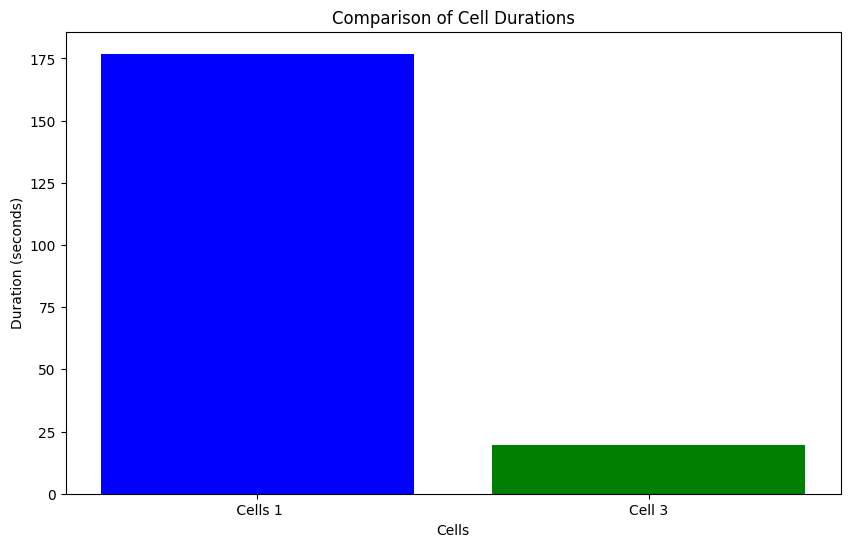

In [29]:
import matplotlib.pyplot as plt

# Data for plotting
labels = [' Cells 1', 'Cell 3']
durations = [duration_cell_1, duration_cell_3]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, durations, color=['blue', 'green'])
plt.xlabel('Cells')
plt.ylabel('Duration (seconds)')
plt.title('Comparison of Cell Durations')
plt.show()
